# CNN Experimentation on Breast Cancer Dataset

In [ ]:
# ## taken from A2
# import os
# import sys

# GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'cnn-bio'
# GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive',GOOGLE_DRIVE_PATH_POST_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

# if 'google.colab' in sys.modules:
#   print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
# else:
#   GOOGLE_DRIVE_PATH = '.'
#   print('Running locally.')

## Downloading Dataset from Kaggle

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized' | wc -l

1694


In [ ]:
! cp "/content/drive/MyDrive/cnn-bio/kaggle.json" ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset
License(s): CC-BY-SA-3.0
100% 4.95G/4.95G [00:57<00:00, 94.8MB/s]
100% 4.95G/4.95G [00:57<00:00, 92.8MB/s]


In [ ]:
! ls '/content/drive/MyDrive/cnn-bio'

breast_cancer_stylized	breast_cancer_stylized.zip  kaggle.json  results


In [ ]:
! unzip cbis-ddsm-breast-cancer-image-dataset.zip -d bc_data
#! unzip cbis-ddsm-breast-cancer-image-dataset.zip -d '/content/drive/MyDrive/cnn-bio/bc_data/'

Streaming output truncated to the last 5000 lines.
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295326067813319071803507885093865003464/1-076.jpg  
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg  
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/2-266.jpg  
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg  
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg  
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295397487412067903910787953980192002590/1-233.jpg  
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/1-294.jpg  
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/2-223.jpg  
  inflating: bc_data/jpeg/1.3.6.1.4.1.9590.100.1.2.295438974411063274614777547962485322182/1-013.jpg  
  inflating: bc_data/j

In [ ]:
! ls '/content/bc_data/jpeg' | wc -l

6774


## Preprocessing Image Dataset

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## DATA PREPROCESSING

In [ ]:
calc_df = pd.read_csv('/content/bc_data/csv/calc_case_description_train_set.csv')
mass_df = pd.read_csv('/content/bc_data/csv/mass_case_description_train_set.csv')
dicom_df = pd.read_csv('/content/bc_data/csv/dicom_info.csv')
meta_df = pd.read_csv('/content/bc_data/csv/meta.csv')

calc_df_test = pd.read_csv('/content/bc_data/csv/calc_case_description_test_set.csv')
mass_df_test = pd.read_csv('/content/bc_data/csv/mass_case_description_test_set.csv')

# taken from https://www.kaggle.com/code/baselanaya/breast-cancer-detection-using-cnn
dicom_cleaned_data = dicom_df.copy()
dicom_cleaned_data.rename(columns={'PatientID': 'patient_id'}, inplace=True)

def fix_label(x):
  x = x.split("_")
  if x[0] == 'P':
    return str(x[0] + "_" + x[1])
  #print(x)
  return str(x[1] + "_" + x[2])


def fix_path(x):
  x = x.replace('CBIS-DDSM/jpeg', img_dir)
  x = x.replace('.jpg', '')
  return x

def fix_pathology(x):
  if x == 'MALIGNANT':
    return 1
  else:
    return 0


dicom_cleaned_data['patient_id'] = dicom_cleaned_data['patient_id'].apply(lambda x: fix_label(x))

dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True)
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

if STYLIZED:
  img_dir = '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized'
else:
  img_dir = '/content/bc_data/jpeg'

dicom_cleaned_data['image_path'] = dicom_cleaned_data['image_path'].apply(lambda x: fix_path(x))

calc_df = calc_df.rename(columns={'pathology': 'calc_pathology'})
mass_df = mass_df.rename(columns={'pathology': 'mass_pathology'})
calc_df['calc_pathology'] = calc_df['calc_pathology'].apply(lambda x: fix_pathology(x))
#calc_df['calc_pathology'] = calc_df['calc_pathology'].astype(int)
calc_df.drop(['image file path', 'cropped image file path','ROI mask file path'],axis =1, inplace=True)
mass_df['mass_pathology'] = mass_df['mass_pathology'].apply(lambda x: fix_pathology(x))
#mass_df['mass_pathology'] = mass_df['mass_pathology'].astype(int)
mass_df.drop(['image file path', 'cropped image file path','ROI mask file path'],axis =1, inplace=True)

dicom_cleaned_data = dicom_cleaned_data[dicom_cleaned_data.SeriesDescription == 'cropped images']

calc_df_test = calc_df_test.rename(columns={'pathology': 'calc_pathology'})
mass_df_test = mass_df_test.rename(columns={'pathology': 'mass_pathology'})
calc_df_test['calc_pathology'] = calc_df_test['calc_pathology'].apply(lambda x: fix_pathology(x))
#calc_df_test['calc_pathology'] = calc_df_test['calc_pathology'].astype(int)
calc_df_test.drop(['image file path', 'cropped image file path','ROI mask file path'],axis =1, inplace=True)
mass_df_test['mass_pathology'] = mass_df_test['mass_pathology'].apply(lambda x: fix_pathology(x))
#mass_df_test['mass_pathology'] = mass_df_test['mass_pathology'].astype(int)
mass_df_test.drop(['image file path', 'cropped image file path','ROI mask file path'],axis =1, inplace=True)

merged_calc_df = pd.merge(dicom_cleaned_data, calc_df, on='patient_id', how='left')
merged_mass_df = pd.merge(dicom_cleaned_data, mass_df, on='patient_id', how='left')

merged_calc_df_test = pd.merge(dicom_cleaned_data, calc_df_test, on='patient_id',how='left')
merged_mass_df_test = pd.merge(dicom_cleaned_data, mass_df_test, on='patient_id', how='left')

merged_calc_df['calc_pathology'] = merged_calc_df['calc_pathology'].fillna(0)
merged_calc_df['calc_pathology'] = merged_calc_df['calc_pathology'].astype(int)

merged_mass_df['mass_pathology'] = merged_mass_df['mass_pathology'].fillna(0)
merged_mass_df['mass_pathology'] = merged_mass_df['mass_pathology'].astype(int)

merged_calc_df_test['calc_pathology'] = merged_calc_df['calc_pathology'].fillna(0)
merged_calc_df_test['calc_pathology'] = merged_calc_df_test['calc_pathology'].astype(int)

merged_mass_df_test['mass_pathology'] = merged_mass_df['mass_pathology'].fillna(0)
merged_mass_df_test['mass_pathology'] = merged_mass_df_test['mass_pathology'].astype(int)

merged_calc_df.drop(['file_path'],axis =1, inplace=True)
merged_mass_df.drop(['file_path'],axis =1, inplace=True)
merged_calc_df_test.drop(['file_path'],axis =1, inplace=True)
merged_mass_df_test.drop(['file_path'],axis =1, inplace=True)


#print(merged_calc_df['calc_pathology'])
# print(merged_mass_df.columns)
# print(merged_calc_df_test.columns)
# print(merged_mass_df_test.columns)

merged_calc_df.to_csv('/content/bc_data/csv/merged_calc.csv', index=False)
merged_mass_df.to_csv('/content/bc_data/csv/merged_mass.csv', index=False)
merged_calc_df_test.to_csv('/content/bc_data/csv/merged_calc_test.csv', index=False)
merged_mass_df_test.to_csv('/content/bc_data/csv/merged_mass_test.csv', index=False)

# merged_total_df.to_csv('/content/bc_data/csv/merged_total.csv', index=False)


<ipython-input-35-31024b24b7f1>:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-35-31024b24b7f1>:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)


### Calcification Image

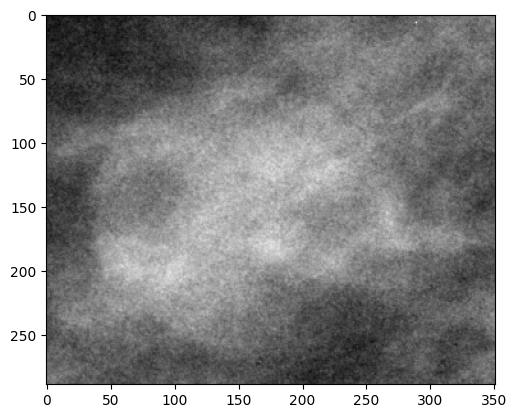

In [ ]:
from PIL import Image

img = merged_calc_df.iloc[0]['image_path'] + ".jpg"
cropped_image = Image.open(img)
gray_img= cropped_image.convert("L")
plt.imshow(gray_img, cmap='gray')

### Mass Image

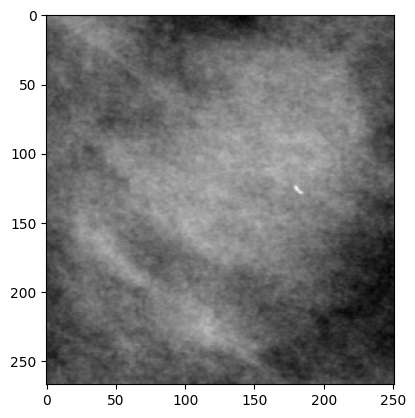

In [ ]:
from PIL import Image

img = merged_mass_df.iloc[72]['image_path'] + ".jpg"
cropped_image = Image.open(img)
gray_img= cropped_image.convert("L")
plt.imshow(gray_img, cmap='gray')

## Developing Training and Testing Set

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from PIL import Image
import pandas as pd
import os
from torchvision.io import read_image

In [ ]:
#based on: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, target, transform=None):
        self.labels_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target = target

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels_frame.iloc[idx, 0] + ".jpg")
        image = Image.open(img_path)

        label = self.labels_frame[self.target].iloc[idx]
        #print('Custom image set' , label)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.int)

        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = read_image(img_path)
        # label = self.img_labels.iloc[idx, 1]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        # return image, label

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.):
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        """
        Implement forward of focal loss
        :param input: input predictions
        :param target: labels
        :return: tensor of focal loss in scalar
        """
        loss = None
        #############################################################################
        # TODO: Implement forward pass of the focal loss                            #
        #############################################################################
        batchSize = input.shape[0]
        numberOfClasses = input.shape[1]
        predictions = F.softmax(input,dim=1)
        targetPredictions = predictions[np.arange(batchSize),target]
        focalLoss = torch.zeros(batchSize)
        for prediction in range(batchSize):
            predicationT = targetPredictions[prediction]
            focalLoss[prediction] = torch.mul(self.weight[target[prediction]],-(torch.pow((1-predicationT),self.gamma))*torch.log(predicationT))
        loss = torch.mean(focalLoss)
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss

In [ ]:
#Define our parameters for ResNet 56
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")

calc_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True,
    "train_dir": '/content/bc_data/csv/merged_calc.csv',
    "test_dir": '/content/bc_data/csv/merged_calc_test.csv',
    "img_dir": '/content/bc_data/jpeg',
    "target": 'calc_pathology'
}

calc_stylized_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True,
    "train_dir": '/content/bc_data/csv/merged_calc.csv',
    "test_dir": '/content/bc_data/csv/merged_calc_test.csv',
    "img_dir": '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized/',
    "target": 'calc_pathology'
}

mass_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True,
    "train_dir": '/content/bc_data/csv/merged_mass.csv',
    "test_dir": '/content/bc_data/csv/merged_mass_test.csv',
    "img_dir": '/content/bc_data/jpeg',
    "target": 'mass_pathology'
}


mass_stylized_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True,
    "train_dir": '/content/bc_data/csv/merged_mass.csv',
    "test_dir": '/content/bc_data/csv/merged_mass_test.csv',
    "img_dir": '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized/',
    "target": 'mass_pathology'
}


total_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True
}

Device : cuda


## RESNET MODEL

In [ ]:
"""
ResNet Model.  (c) 2021 Georgia Tech

Copyright 2021, Georgia Institute of Technology (Georgia Tech)
Atlanta, Georgia 30332
All Rights Reserved

Template code for CS 7643 Deep Learning

Georgia Tech asserts copyright ownership of this template and all derivative
works, including solutions to the projects assigned in this course. Students
and other users of this template code are advised not to share it with others
or to make it available on publicly viewable websites including repositories
such as Github, Bitbucket, and Gitlab.  This copyright statement should
not be removed or edited.

Sharing solutions with current or future students of CS 7643 Deep Learning is
prohibited and subject to being investigated as a GT honor code violation.

-----do not edit anything above this line---
"""

'''
Properly implemented ResNet for CIFAR10 as described in paper [1].
The implementation and structure of this file is hugely influenced by [2]
which is implemented for ImageNet and doesn't have option A for identity.
Moreover, most of the implementations on the web is copy-paste from
torchvision's resnet and has wrong number of params.
Proper ResNet-s for CIFAR10 (for fair comparision and etc.) has following
number of layers and parameters:
name      | layers | params
ResNet20  |    20  | 0.27M
ResNet32  |    32  | 0.46M
ResNet44  |    44  | 0.66M
ResNet56  |    56  | 0.85M
ResNet110 |   110  |  1.7M
ResNet1202|  1202  | 19.4m
which this implementation indeed has.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
[2] https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
If you use this implementation in you work, please don't forget to mention the
author, Yerlan Idelbayev.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['ResNet_s', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def hello_do_you_copy():
    """
    This is a sample function that we will try to import and run to ensure that
    our environment is correctly set up on Google Colab.
    """
    print("Roger that from resnet.py!")

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16


        #self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet_s(BasicBlock, [3, 3, 3])


def resnet32(num_classes=10, use_norm=False):
    return ResNet_s(BasicBlock, [5, 5, 5], num_classes=num_classes)


def resnet44():
    return ResNet_s(BasicBlock, [7, 7, 7])


def resnet56(num_classes=10):
    return ResNet_s(BasicBlock, [9, 9, 9], num_classes=num_classes)


def resnet110():
    return ResNet_s(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet_s(BasicBlock, [200, 200, 200])


def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()


resnet20
Total number of params 269434
Total layers 20

resnet32
Total number of params 463866
Total layers 32

resnet44
Total number of params 658298
Total layers 44

resnet56
Total number of params 852730
Total layers 56

resnet110
Total number of params 1727674
Total layers 110

resnet1202
Total number of params 19420986
Total layers 1202



## SOLVER CLASS FOR TESTING CNN

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import time
import copy
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

def reweight(cls_num_list, beta=0.9999):
    """
    Implement reweighting by effective numbers
    :param cls_num_list: a list containing # of samples of each class
    :param beta: hyper-parameter for reweighting, see paper for more details
    :return:
    """

    #############################################################################
    # TODO: reweight each class by effective numbers                            #
    #############################################################################
    numberOfClasses = len(cls_num_list)
    per_cls_weights = torch.zeros(numberOfClasses)
    for label in range(numberOfClasses):
        numberOfSamples = cls_num_list[label]
        per_cls_weights[label] = np.divide((1 - beta),(1 - np.power(beta,numberOfSamples)))
    normalizationFactor = numberOfClasses/torch.sum(per_cls_weights)
    per_cls_weights = normalizationFactor*per_cls_weights
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    return per_cls_weights

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class Solver(object):

    def __init__(self, **kwargs):
        self.path_prefix = kwargs.pop('path_prefix', '.')
        self.imbalance = kwargs.pop('imbalance', 'regular')
        self.batch_size = kwargs.pop('batch_size', 128)
        #self.model_type = kwargs.pop('model', 'TwoLayerNet')
        self.model_type = kwargs.pop('model', 'ResNet-56')
        self.device = kwargs.pop("device", "cpu")
        #self.device = kwargs.pop("device", "gpu")
        self.loss_type = kwargs.pop('loss_type', 'FL')
        self.lr = kwargs.pop('learning_rate', 0.0001)
        self.momentum = kwargs.pop('momentum', 0.9)
        self.reg = kwargs.pop('reg', 0.0005)
        self.beta = kwargs.pop('beta', 0.9999)
        self.gamma = kwargs.pop('gamma', 1.0)
        self.steps = kwargs.pop('steps', [6, 8])
        self.epochs = kwargs.pop('epochs', 10)
        self.warmup = kwargs.pop('warmup', 0)
        self.save_best = kwargs.pop('save_best', True)
        self.train_dir = kwargs.pop('train_dir', None)
        self.test_dir = kwargs.pop('test_dir', None)
        self.img_dir = kwargs.pop('img_dir', None)
        self.target = kwargs.pop('target', None)

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        #define train datasets
        trainDataDir = self.img_dir
        trainLabelDir = self.train_dir

        transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize images to a fixed size
        transforms.ToTensor()            # Convert images to tensors
        ])

        batch_size = 32
        csv = pd.read_csv(trainLabelDir)

        # Create dataset instances
        trainDataset = CustomImageDataset(csv_file=trainLabelDir, img_dir=trainDataDir, target=self.target, transform=transform)

        # Define the split ratio
        train_ratio = 0.8
        train_size = int(train_ratio * len(trainDataset))
        val_size = len(trainDataset) - train_size

        #print("Train size " , train_size)
        #print("Val size " , val_size)

        # Randomly split the dataset
        trainDataset, valDataset = random_split(trainDataset, [train_size, val_size])

        #Define loss
        trainFrame = pd.read_csv(trainLabelDir)
        target = self.target
        cls_num_list = trainFrame[target].value_counts().to_dict()
        per_cls_weights = reweight(cls_num_list, beta=self.beta)
        per_cls_weights = per_cls_weights.to(self.device)

        # Create DataLoader
        self.train_loader = DataLoader(trainDataset, batch_size=32, shuffle=True)
        self.val_loader = DataLoader(valDataset, batch_size=32, shuffle=False)

        #Define Model
        if self.model_type == 'MyModel':
            self.model = MyModel()
        elif self.model_type == 'ResNet-56':
            self.model = resnet56()
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.model.to(device)

        #Define loss function
        if self.loss_type == 'CE':
            self.criterion = nn.CrossEntropyLoss()
        else:
            self.criterion = FocalLoss(weight=per_cls_weights,gamma=self.gamma)

        self.criterion.to(self.device)

        self.optimizer = torch.optim.SGD(self.model.parameters(),
                                         self.lr,
                                         momentum=self.momentum,
                                         weight_decay=self.reg)
        self._reset()

    def _reset(self):
        self.best = 0.0
        self.best_cm = None
        self.best_model = None

    def train(self):
        for epoch in range(self.epochs):
            self._adjust_learning_rate(epoch)

            # train loop
            self._train_step(epoch)
            acc, cm = self._evaluate(epoch)

            if acc > self.best:
                self.best = acc
                self.best_cm = cm
                self.best_model = copy.deepcopy(self.model)

        print('Best Prec @1 Acccuracy: {:.4f}'.format(self.best))
        per_cls_acc = self.best_cm.diag().detach().numpy().tolist()
        for i, acc_i in enumerate(per_cls_acc):
            print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

        if self.save_best:
            #basedir = pathlib.Path(__file__).parent.resolve()
            basedir = '/content/drive/MyDrive/cnn-bio/results'
            torch.save(
                self.best_model.state_dict(),
                str(basedir) + '/checkpoints/' + self.model_type.lower() +
                '.pth')

    def _train_step(self, epoch):
        iter_time = AverageMeter()
        losses = AverageMeter()
        acc = AverageMeter()

        self.model.train()

        for idx, (data, target) in enumerate(self.train_loader):
            start = time.time()

            data = data.to(self.device)
            target = target.to(self.device)

            #print(target.shape)

            out, loss = self._compute_loss_update_params(data, target)

            batch_acc = self._check_accuracy(out, target)

            losses.update(loss.item(), out.shape[0])
            acc.update(batch_acc, out.shape[0])

            iter_time.update(time.time() - start)
            if idx % 10 == 0:
                print(('Epoch: [{0}][{1}/{2}]\t'
                       'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t'
                       'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                       'Prec @1 {top1.val:.4f} ({top1.avg:.4f})\t').format(
                           epoch,
                           idx,
                           len(self.train_loader),
                           iter_time=iter_time,
                           loss=losses,
                           top1=acc))

        self.train_losses.append(losses.avg)
        self.train_accuracies.append(acc.avg)


    def _evaluate(self, epoch):
            iter_time = AverageMeter()
            losses = AverageMeter()
            acc = AverageMeter()

            num_class = 10
            cm = torch.zeros(num_class, num_class, dtype=torch.float64)
            self.model.eval()

            # evaluation loop
            for idx, (data, target) in enumerate(self.val_loader):
                start = time.time()

                data = data.to(self.device)
                target = target.to(self.device)

                out, loss = self._compute_loss_update_params(data, target)

                batch_acc = self._check_accuracy(out, target)

                # update confusion matrix
                _, preds = torch.max(out, 1)
                for t, p in zip(target.view(-1), preds.view(-1)):
                    cm[t.long(), p.long()] += 1

                losses.update(loss.item(), out.shape[0])
                acc.update(batch_acc, out.shape[0])

                iter_time.update(time.time() - start)
                if idx % 10 == 0:
                    print((
                        'Epoch: [{0}][{1}/{2}]\t'
                        'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t').format(
                            epoch,
                            idx,
                            len(self.val_loader),
                            iter_time=iter_time,
                            loss=losses,
                            top1=acc))
            cm = cm / cm.sum(1)
            per_cls_acc = cm.diag().detach().numpy().tolist()
            for i, acc_i in enumerate(per_cls_acc):
                print("Accuracy of Class {}: {:.4f}".format(i, acc_i))

            print("* Prec @1: {top1.avg:.4f}".format(top1=acc))

            self.val_losses.append(losses.avg)
            self.val_accuracies.append(acc.avg)
            return acc.avg, cm

    def _check_accuracy(self, output, target):
        """Computes the precision@k for the specified values of k"""
        batch_size = target.shape[0]

        _, pred = torch.max(output, dim=-1)

        correct = pred.eq(target).sum() * 1.0

        acc = correct / batch_size

        return acc

    def _compute_loss_update_params(self, data, target):
        output = None
        loss = None
        if self.model.training:
            #############################################################################
            # TODO: Complete the body of training loop                                  #
            #       1. forward data batch to the model                                  #
            #       2. Compute batch loss                                               #
            #       3. Compute gradients and update model parameters                    #
            #############################################################################
            output = self.model.forward(data)
            loss = self.criterion.forward(output,target)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            #############################################################################
            #                              END OF YOUR CODE                             #
            #############################################################################
        else:
            #############################################################################
            # TODO: Complete the body of training loop                                  #
            #       HINT: torch.no_grad()                                               #
            #############################################################################
            with torch.no_grad():
                output = self.model.forward(data)
                loss = self.criterion.forward(output,target)
            #############################################################################
            #                              END OF YOUR CODE                             #
            #############################################################################

        return output, loss

    def _adjust_learning_rate(self, epoch):
        epoch += 1
        if epoch <= self.warmup:
            lr = self.lr * epoch / self.warmup
        elif epoch > self.steps[1]:
            lr = self.lr * 0.01
        elif epoch > self.steps[0]:
            lr = self.lr * 0.1
        else:
            lr = self.lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr


    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        # Train Loss
        plt.subplot(1, 2, 1)
        if isinstance(self.train_losses, torch.Tensor):
            train_losses = self.train_losses.cpu().numpy()  # Convert CUDA tensor to numpy
        else:
            train_losses = self.train_losses  # Assuming it's already in a compatible format
        plt.plot(train_losses, label='Train Loss')

        if isinstance(self.val_losses, torch.Tensor):
            val_losses = self.val_losses.cpu().numpy()
        else:
            val_losses = self.val_losses
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Train Accuracy
        plt.subplot(1, 2, 2)
        if isinstance(self.train_accuracies, torch.Tensor):
            train_accuracies = self.train_accuracies.cpu().numpy()
        elif isinstance(self.train_accuracies, list) and all(isinstance(x, torch.Tensor) for x in self.train_accuracies):
            train_accuracies = [x.cpu().item() for x in self.train_accuracies]  # Convert each tensor to scalar
        else:
            train_accuracies = self.train_accuracies

        plt.plot(train_accuracies, label='Train Accuracy')

        if isinstance(self.val_accuracies, torch.Tensor):
            val_accuracies = self.val_accuracies.cpu().numpy()
        elif isinstance(self.val_accuracies, list) and all(isinstance(x, torch.Tensor) for x in self.val_accuracies):
            val_accuracies = [x.cpu().item() for x in self.val_accuracies]
        else:
            val_accuracies = self.val_accuracies

        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()



    def evaluate_test(self, test_loader):
        losses = AverageMeter()
        accuracies = AverageMeter()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                pred = output.argmax(dim=1, keepdim=False)  # Simplify dim to match target

                correct = pred.eq(target).sum().item()
                accuracy = correct / len(data)

                losses.update(loss.item(), data.size(0))
                accuracies.update(accuracy, data.size(0))

                all_preds.extend(pred.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        # Print loss and accuracy
        print(f"Test Loss: {losses.avg:.4f}, Test Accuracy: {accuracies.avg * 100:.2f}%")

        # Classification report and confusion matrix
        #print("\nClassification Report:")
        #print(classification_report(all_targets, all_preds, target_names=test_loader.target))

        print("Confusion Matrix:")
        print(confusion_matrix(all_targets, all_preds))

        return losses.avg, accuracies.avg



### Kwargs

In [ ]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")

calc_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True,
    "train_dir": '/content/bc_data/csv/merged_calc.csv',
    "test_dir": '/content/bc_data/csv/merged_calc_test.csv',
    "img_dir": '/content/bc_data/jpeg',
    "target": 'calc_pathology'
}

calc_stylized_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True,
    "train_dir": '/content/bc_data/csv/merged_calc.csv',
    "test_dir": '/content/bc_data/csv/merged_calc_test.csv',
    "img_dir": '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized/',
    "target": 'calc_pathology'
}

mass_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True,
    "train_dir": '/content/bc_data/csv/merged_mass.csv',
    "test_dir": '/content/bc_data/csv/merged_mass_test.csv',
    "img_dir": '/content/bc_data/jpeg',
    "target": 'mass_pathology'
}


mass_stylized_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True,
    "train_dir": '/content/bc_data/csv/merged_mass.csv',
    "test_dir": '/content/bc_data/csv/merged_mass_test.csv',
    "img_dir": '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized/',
    "target": 'mass_pathology'
}


total_kwargs = {
    "path_prefix": '.',
    "imbalance": 'imbalance',
    "batch_size": 32,
    "model": 'ResNet-56',
    "device": device,
    "loss_type": 'Focal',
    "learning_rate": 0.01,
    "momentum": 0.95,
    "reg": 0.005,
    "beta": 0.9999,
    "gamma": 1.0,
    "steps": [6,8],
    "epochs":10,
    "warmup":0,
    "save_best":True
}

Device : cuda


## Calc Train Model

In [ ]:
solver = Solver(**calc_stylized_kwargs)
solver.train()

Epoch: [0][0/245]	Time 0.183 (0.183)	Loss 1.1368 (1.1368)	Prec @1 0.0312 (0.0312)	
Epoch: [0][10/245]	Time 0.135 (0.138)	Loss 0.1984 (0.3752)	Prec @1 0.5625 (0.6420)	
Epoch: [0][20/245]	Time 0.181 (0.138)	Loss 0.1823 (0.3201)	Prec @1 0.4688 (0.5952)	
Epoch: [0][30/245]	Time 0.136 (0.138)	Loss 0.4890 (0.2925)	Prec @1 0.4062 (0.6129)	
Epoch: [0][40/245]	Time 0.161 (0.138)	Loss 0.4355 (0.2864)	Prec @1 0.8438 (0.6105)	
Epoch: [0][50/245]	Time 0.169 (0.136)	Loss 0.2365 (0.2794)	Prec @1 0.3750 (0.6085)	
Epoch: [0][60/245]	Time 0.170 (0.136)	Loss 0.2567 (0.2733)	Prec @1 0.3438 (0.6014)	
Epoch: [0][70/245]	Time 0.200 (0.139)	Loss 0.1832 (0.2616)	Prec @1 0.5000 (0.6092)	
Epoch: [0][80/245]	Time 0.184 (0.143)	Loss 0.1273 (0.2485)	Prec @1 0.9062 (0.6250)	
Epoch: [0][90/245]	Time 0.087 (0.142)	Loss 0.0686 (0.2435)	Prec @1 0.9688 (0.6298)	
Epoch: [0][100/245]	Time 0.145 (0.140)	Loss 0.3878 (0.2422)	Prec @1 0.8125 (0.6340)	
Epoch: [0][110/245]	Time 0.099 (0.139)	Loss 0.1508 (0.2361)	Prec @1 0.8750 (

### Graphs

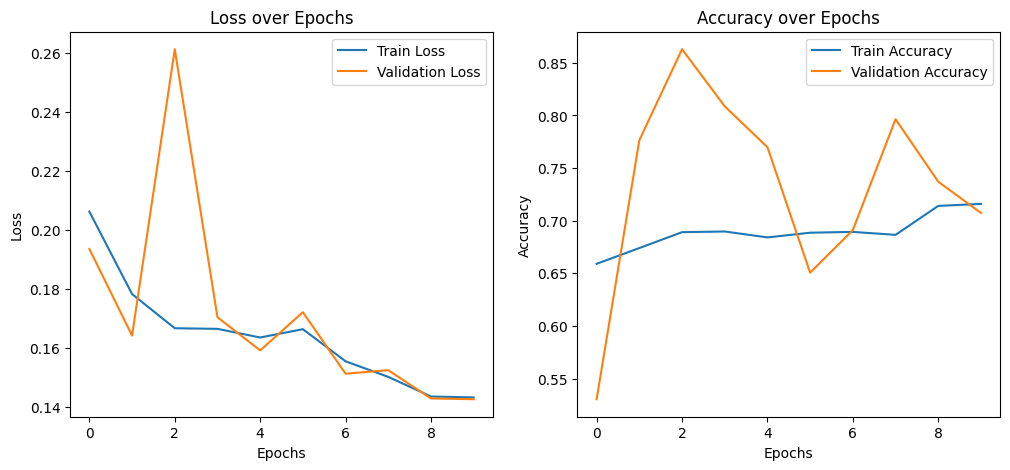

In [ ]:
solver.plot_metrics()

## Calc Set

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

#dir = '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized'
testDataset = CustomImageDataset(csv_file='/content/bc_data/csv/merged_calc_test.csv', img_dir='/', target='calc_pathology', transform=test_transform)
test_loader = DataLoader(testDataset, batch_size=32, shuffle=False)

In [ ]:
test_loss, test_accuracy = solver.evaluate_test(test_loader)

Test Loss: 0.3022, Test Accuracy: 50.95%
Confusion Matrix:
[[2196 1997]
 [ 455  351]]


In [ ]:
#plot_confusion_matrix(solver.model, test_loader)

## Stylized Calc Set

In [ ]:
merged_calc_df_test = pd.read_csv('/content/bc_data/csv/merged_calc_test.csv')
merged_calc_df_test['image_path']

dir = '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized'

def fix_path_stylized(x, dir):
  x = x.replace('/content/bc_data/jpeg', dir)
  x = x.replace('.jpg', '')
  return x


merged_calc_df_test_stylized = merged_calc_df_test.copy()
merged_calc_df_test_stylized['image_path'] = merged_calc_df_test_stylized['image_path'].apply(lambda x: fix_path_stylized(x, dir))
print(merged_calc_df_test_stylized.iloc[0]['image_path'])
merged_calc_df_test_stylized.to_csv('/content/bc_data/csv/merged_calc_test_stylized.csv', index=False)


/content/drive/MyDrive/cnn-bio/breast_cancer_stylized/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172


In [ ]:
#! ls '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized'

In [ ]:
import os
import pandas as pd

def find_and_filter_image_paths(root_dir, dataframe_path, output_csv_path):
    # Step 1: Recursively find all .jpg image paths in the directory and subdirectories
    valid_extensions = ('.jpg')  # Only look for .jpg images
    image_paths = []

    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(valid_extensions):
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
                #print(full_path)

    # Step 2: Load the dataframe
    df = pd.read_csv(dataframe_path)

    # Step 3: Filter the dataframe to only include rows where the image path is in the list of found image paths
    # Ensure paths in df['image_path'] are absolute paths or adjust accordingly
    #print(df['image_path'].iloc[0])
    df['image_path'] = df['image_path'].apply(lambda x: x + '.jpg')
    #print(df['image_path'].iloc[0]
    filtered_df = df[df['image_path'].isin(image_paths)]
    filtered_df['image_path'] = filtered_df['image_path'].apply(lambda x: x.replace('.jpg', ''))

    # Step 4: Write the filtered dataframe to a new CSV file
    filtered_df.to_csv(output_csv_path, index=False)
    print(f"Filtered dataframe written to {output_csv_path} with {len(filtered_df)} entries.")

# Usage Example
root_directory = '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized'  # Root directory containing images
dataframe_path = '/content/bc_data/csv/merged_calc_test_stylized.csv'  # Path to your CSV file containing the 'image_path' column
output_csv_path = '/content/bc_data/csv/merged_calc_test_stylized_fixed_1.csv'  # Path to write the filtered CSV file

find_and_filter_image_paths(root_directory, dataframe_path, output_csv_path)


Filtered dataframe written to /content/bc_data/csv/merged_calc_test_stylized_fixed_1.csv with 1210 entries.


<ipython-input-169-2c4cfb95bfae>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['image_path'] = filtered_df['image_path'].apply(lambda x: x.replace('.jpg', ''))


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dir = '/'

testDataset = CustomImageDataset(csv_file='/content/bc_data/csv/merged_calc_test_stylized_fixed_1.csv', img_dir=dir, target='calc_pathology', transform=transform)
test_loader = DataLoader(testDataset, batch_size=32, shuffle=False)

In [ ]:
test_loss, test_accuracy = solver.evaluate_test(test_loader)

Test Loss: 0.3446, Test Accuracy: 37.19%
Confusion Matrix:
[[315 701]
 [ 59 135]]


## MASS TEST

In [ ]:
solver = Solver(**mass_stylized_kwargs)
solver.train()

Epoch: [0][0/150]	Time 0.153 (0.153)	Loss 2.8727 (2.8727)	Prec @1 0.3125 (0.3125)	
Epoch: [0][10/150]	Time 0.088 (0.122)	Loss 0.4784 (1.7024)	Prec @1 0.6562 (0.4318)	
Epoch: [0][20/150]	Time 0.095 (0.124)	Loss 0.4725 (1.3226)	Prec @1 0.7188 (0.4658)	
Epoch: [0][30/150]	Time 0.156 (0.120)	Loss 0.5958 (1.0896)	Prec @1 0.2812 (0.5181)	
Epoch: [0][40/150]	Time 0.129 (0.122)	Loss 0.6309 (0.9416)	Prec @1 0.5938 (0.4970)	
Epoch: [0][50/150]	Time 0.199 (0.128)	Loss 0.6895 (0.8890)	Prec @1 0.3438 (0.5159)	
Epoch: [0][60/150]	Time 0.151 (0.127)	Loss 0.3714 (0.8176)	Prec @1 0.6875 (0.5164)	
Epoch: [0][70/150]	Time 0.110 (0.125)	Loss 0.3602 (0.7530)	Prec @1 0.2812 (0.4965)	
Epoch: [0][80/150]	Time 0.158 (0.128)	Loss 0.2920 (0.7004)	Prec @1 0.7812 (0.4954)	
Epoch: [0][90/150]	Time 0.112 (0.126)	Loss 0.2773 (0.6542)	Prec @1 0.2812 (0.5141)	
Epoch: [0][100/150]	Time 0.200 (0.126)	Loss 0.2608 (0.6174)	Prec @1 0.6562 (0.5093)	
Epoch: [0][110/150]	Time 0.107 (0.127)	Loss 0.2929 (0.5892)	Prec @1 0.3750 (

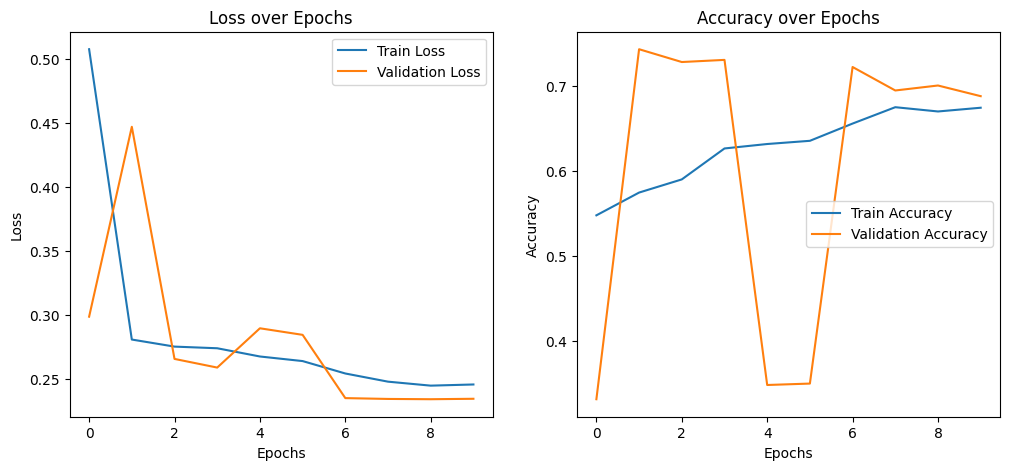

In [ ]:
solver.plot_metrics()

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

testDataset = CustomImageDataset(csv_file='/content/bc_data/csv/merged_mass_test.csv', img_dir='/', target='mass_pathology', transform=test_transform)
test_loader = DataLoader(testDataset, batch_size=32, shuffle=False)

In [ ]:
test_loss, test_accuracy = solver.evaluate_test(test_loader)

Test Loss: 0.3219, Test Accuracy: 54.13%
Confusion Matrix:
[[1923 1331]
 [ 687  458]]


In [ ]:
#solver.plot_confusion_matrix(solver.model, test_loader)

## Stylized Mass Test

In [ ]:
merged_mass_df_test = pd.read_csv('/content/bc_data/csv/merged_mass_test.csv')
merged_mass_df_test['image_path']

dir = '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized'

def fix_path_stylized(x, dir):
  x = x.replace('/content/bc_data/jpeg', dir)
  x = x.replace('.jpg', '')
  return x


merged_mass_df_test_stylized = merged_mass_df_test.copy()
merged_mass_df_test_stylized['image_path'] = merged_mass_df_test_stylized['image_path'].apply(lambda x: fix_path_stylized(x, dir))
print(merged_mass_df_test_stylized.iloc[0]['image_path'])
merged_mass_df_test_stylized.to_csv('/content/bc_data/csv/merged_mass_test_stylized.csv', index=False)

/content/drive/MyDrive/cnn-bio/breast_cancer_stylized/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172


In [ ]:
import os
import pandas as pd

def find_and_filter_image_paths(root_dir, dataframe_path, output_csv_path):
    # Step 1: Recursively find all .jpg image paths in the directory and subdirectories
    valid_extensions = ('.jpg')  # Only look for .jpg images
    image_paths = []

    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(valid_extensions):
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
                #print(full_path)

    # Step 2: Load the dataframe
    df = pd.read_csv(dataframe_path)

    # Step 3: Filter the dataframe to only include rows where the image path is in the list of found image paths
    # Ensure paths in df['image_path'] are absolute paths or adjust accordingly
    #print(df['image_path'].iloc[0])
    df['image_path'] = df['image_path'].apply(lambda x: x + '.jpg')
    #print(df['image_path'].iloc[0]
    filtered_df = df[df['image_path'].isin(image_paths)]
    filtered_df['image_path'] = filtered_df['image_path'].apply(lambda x: x.replace('.jpg', ''))

    # Step 4: Write the filtered dataframe to a new CSV file
    filtered_df.to_csv(output_csv_path, index=False)
    print(f"Filtered dataframe written to {output_csv_path} with {len(filtered_df)} entries.")

# Usage Example
root_directory = '/content/drive/MyDrive/cnn-bio/breast_cancer_stylized'  # Root directory containing images
dataframe_path = '/content/bc_data/csv/merged_mass_test_stylized.csv'  # Path to your CSV file containing the 'image_path' column
output_csv_path = '/content/bc_data/csv/merged_mass_test_stylized_fixed_1.csv'  # Path to write the filtered CSV file

find_and_filter_image_paths(root_directory, dataframe_path, output_csv_path)


Filtered dataframe written to /content/bc_data/csv/merged_mass_test_stylized_fixed_1.csv with 1072 entries.


<ipython-input-177-186ae42b6555>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['image_path'] = filtered_df['image_path'].apply(lambda x: x.replace('.jpg', ''))


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dir = '/'

testDataset = CustomImageDataset(csv_file='/content/bc_data/csv/merged_mass_test_stylized_fixed_1.csv', img_dir=dir, target='mass_pathology', transform=transform)
test_loader = DataLoader(testDataset, batch_size=32, shuffle=False)

In [ ]:
test_loss, test_accuracy = solver.evaluate_test(test_loader)

Test Loss: 0.4124, Test Accuracy: 70.34%
Confusion Matrix:
[[740  34]
 [284  14]]
